# Header-Based Markdown Chunking for RAG System

This notebook implements a header-based chunking strategy specifically optimized for Markdown content. Instead of using fixed-size chunking, we'll create semantically coherent chunks based on the document's header structure (## and ### headings), which preserves the natural organization of the content.

In [1]:
# Import required libraries
import os
import json
import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import logging
from datetime import datetime

# Import LangChain's Document object for compatibility with vector stores
from langchain_core.documents import Document

In [2]:
# --- Configuration ---
# Input directory for markdown files
INPUT_MARKDOWN_DIR = "../data/markdown_clean_final"
# Output directory for chunked JSON files
OUTPUT_CHUNKS_DIR = "../data/chunks"
# Output directory for log files
LOGS_DIR = "../logs"

# Create directories if they don't exist
Path(OUTPUT_CHUNKS_DIR).mkdir(parents=True, exist_ok=True)
Path(LOGS_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
# Set up logging
log_file = Path(LOGS_DIR) / f"header_chunking_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(module)s - %(funcName)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file, encoding='utf-8'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [4]:
def parse_frontmatter(content):
    """
    Parse markdown frontmatter without external YAML dependencies.
    
    Args:
        content (str): Markdown content with YAML frontmatter
        
    Returns:
        tuple: (metadata_dict, content_without_frontmatter)
    """
    if not content.startswith('---'):
        logger.debug("No frontmatter found (doesn't start with '---').")
        return {}, content
    
    parts = content.split('---', 2)
    if len(parts) < 3:
        logger.debug("Invalid frontmatter structure (not enough '---' separators).")
        return {}, content # Not a valid frontmatter structure
    
    frontmatter_text = parts[1].strip()
    content_text = parts[2].strip() # The rest of the document
    
    metadata = {}
    for line in frontmatter_text.splitlines():
        line = line.strip()
        if not line or ':' not in line:
            continue
        
        key, value = line.split(':', 1)
        key = key.strip()
        value = value.strip()
        
        # Remove quotes if present (handles both single and double)
        if (value.startswith('"') and value.endswith('"')) or \
           (value.startswith("'") and value.endswith("'")):
            value = value[1:-1]
            
        metadata[key] = value
    
    logger.debug(f"Parsed frontmatter: {metadata}")
    return metadata, content_text

In [5]:
def extract_file_category(file_path):
    """
    Extract category from file path based on filename pattern.
    For example: people_*.md -> 'people', news_*.md -> 'news', etc.
    """
    file_name = Path(file_path).name
    parts = file_name.split('_')
    if len(parts) > 0:
        return parts[0]
    return "unknown"

In [6]:
def split_markdown_by_headers(file_path):
    """
    Split a markdown file into chunks using headers (## and ###) as boundaries.
    
    Args:
        file_path (str or Path): Path to the markdown file
        
    Returns:
        list: List of LangChain Document objects with content and metadata
    """
    file_path = Path(file_path)
    logger.info(f"Processing file: {file_path}")
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            full_file_content = f.read()
    except Exception as e:
        logger.error(f"Could not read file {file_path}: {e}")
        return []
    
    # Extract metadata from frontmatter
    metadata, text_content = parse_frontmatter(full_file_content)
    
    # Add source information to metadata
    metadata['source_file'] = str(file_path.resolve())
    metadata['filename'] = file_path.name
    metadata['category'] = extract_file_category(file_path)
    
    # Define header pattern to match markdown headers (## or ###) and capture their content
    # This regex pattern will find headers along with all content until the next header
    header_pattern = r'^(#{2,3})\s+(.+?)\n([\s\S]*?)(?=^#{2,3}\s+|\Z)'
    
    # Find all headers and their content sections
    matches = re.finditer(header_pattern, text_content, re.MULTILINE)
    
    processed_chunks = []
    chunk_id = 0
    main_section = None  # Track the current main section (## level)
    current_section_hierarchy = {}  # Track the hierarchy of sections
    
    for match in matches:
        header_level = len(match.group(1))  # How many # symbols (2 for ##, 3 for ###)
        header_text = match.group(2).strip()
        section_content = match.group(3).strip()
        
        # Skip empty sections
        if not section_content:
            logger.debug(f"Skipping empty section: {header_text}")
            continue
        
        # Create chunk metadata
        chunk_metadata = metadata.copy()
        
        # Track header hierarchy
        if header_level == 2:  # ## Main section
            main_section = header_text
            current_section_hierarchy = {2: header_text}  # Reset subsections when main section changes
            chunk_metadata['section_level'] = 'main'
            chunk_metadata['section'] = header_text
            chunk_metadata['subsection'] = None
        elif header_level == 3:  # ### Subsection
            current_section_hierarchy[3] = header_text
            chunk_metadata['section_level'] = 'subsection'
            chunk_metadata['section'] = current_section_hierarchy.get(2, "Unknown")
            chunk_metadata['subsection'] = header_text
        
        # Add header info and chunk identification to metadata
        chunk_metadata['header_level'] = header_level
        chunk_metadata['header_text'] = header_text
        chunk_metadata['chunk_id'] = f"{file_path.stem}_{chunk_id}"
        chunk_metadata['document_title'] = metadata.get('title', file_path.stem)
        
        # Include the header in the chunk content for context
        chunk_content = f"{'#' * header_level} {header_text}\n\n{section_content}"
        
        # Create a LangChain Document object
        try:
            doc = Document(page_content=chunk_content, metadata=chunk_metadata)
            processed_chunks.append(doc)
            chunk_id += 1
        except Exception as e:
            logger.error(f"Error creating Document object for section '{header_text}': {e}")
            # Fallback to dictionary if Document creation fails
            processed_chunks.append({
                'page_content': chunk_content,
                'metadata': chunk_metadata,
                'error_creating_document': True
            })
    
    # Handle case where no headers were found, chunk the entire document as one
    if len(processed_chunks) == 0:
        logger.warning(f"No headers found in {file_path.name}, using entire document as one chunk")
        # Extract document title if possible
        title_match = re.search(r'^\s*#\s+(.+?)(?:\n|$)', text_content, re.MULTILINE)
        if title_match:
            title = title_match.group(1).strip()
            metadata['document_title'] = title
        metadata['chunk_id'] = f"{file_path.stem}_0"
        metadata['section_level'] = 'document'
        doc = Document(page_content=text_content, metadata=metadata)
        processed_chunks.append(doc)
    
    logger.info(f"Split '{file_path.name}' into {len(processed_chunks)} header-based chunks")
    return processed_chunks

In [7]:
def process_markdown_directory(input_dir_path_str, output_dir_path_str):
    """
    Process all markdown files in a directory, chunk them by headers, and save the chunks.
    """
    input_path = Path(input_dir_path_str)
    output_path = Path(output_dir_path_str)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Find all markdown files
    markdown_files = list(input_path.rglob("*.md"))
    logger.info(f"Found {len(markdown_files)} markdown files in '{input_path}' and its subdirectories")
    
    if not markdown_files:
        logger.warning(f"No markdown files found in {input_path}. Exiting.")
        return 0, 0
    
    all_chunks_list = []
    total_files_processed = 0
    
    # Process each markdown file
    for md_file in tqdm(markdown_files, desc="Processing Markdown Files"):
        chunks = split_markdown_by_headers(md_file)
        
        if chunks:
            total_files_processed += 1
            
            # Convert Document objects to dictionaries for JSON serialization
            chunks_serializable = []
            for chunk in chunks:
                if isinstance(chunk, Document):
                    chunks_serializable.append({
                        "page_content": chunk.page_content,
                        "metadata": chunk.metadata
                    })
                else:  # Already a dict (fallback case)
                    chunks_serializable.append(chunk)
            
            # Add to the consolidated list
            all_chunks_list.extend(chunks_serializable)
            
            # Save individual file chunks
            # Create mirrored directory structure
            relative_path = md_file.relative_to(input_path)
            output_dir = output_path / relative_path.parent
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Save to individual JSON file
            output_json_path = output_dir / f"{md_file.stem}_chunks.json"
            try:
                with open(output_json_path, "w", encoding="utf-8") as f:
                    json.dump(chunks_serializable, f, indent=2, ensure_ascii=False)
                logger.info(f"Saved {len(chunks_serializable)} chunks for {md_file.name} to {output_json_path}")
            except Exception as e:
                logger.error(f"Error saving chunks for {md_file.name}: {e}")
    
    # Save all chunks to a consolidated file
    if all_chunks_list:
        all_chunks_file = output_path / "all_chunks_by_header.json"
        try:
            with open(all_chunks_file, "w", encoding="utf-8") as f:
                json.dump(all_chunks_list, f, indent=2, ensure_ascii=False)
            logger.info(f"Saved all {len(all_chunks_list)} chunks to {all_chunks_file}")
        except Exception as e:
            logger.error(f"Error saving consolidated chunks file: {e}")
    
    return total_files_processed, len(all_chunks_list)

In [8]:
def analyze_chunks(all_chunks_file):
    """
    Analyze the distribution of chunks to provide insights on the chunking results.
    """
    all_chunks_path = Path(all_chunks_file)
    if not all_chunks_path.exists():
        logger.error(f"Consolidated chunks file not found: {all_chunks_path}")
        return None
    
    try:
        with open(all_chunks_path, "r", encoding="utf-8") as f:
            chunks_data = json.load(f)
    except Exception as e:
        logger.error(f"Error loading chunks file: {e}")
        return None
    
    if not chunks_data:
        logger.warning("No chunks found for analysis")
        return None
    
    # Extract data for analysis
    chunk_lengths = [len(chunk["page_content"]) for chunk in chunks_data]
    categories = [chunk["metadata"].get("category", "unknown") for chunk in chunks_data]
    section_levels = [chunk["metadata"].get("section_level", "unknown") for chunk in chunks_data]
    header_levels = [chunk["metadata"].get("header_level", 0) for chunk in chunks_data]
    
    # Create DataFrame for analysis
    df = pd.DataFrame({
        "length": chunk_lengths,
        "category": categories,
        "section_level": section_levels,
        "header_level": header_levels
    })
    
    # Basic statistics
    logger.info(f"\n--- Chunk Analysis ---")
    logger.info(f"Total chunks: {len(chunks_data)}")
    logger.info(f"Average chunk length: {df['length'].mean():.2f} characters")
    logger.info(f"Median chunk length: {df['length'].median():.2f} characters")
    logger.info(f"Min chunk length: {df['length'].min()} characters")
    logger.info(f"Max chunk length: {df['length'].max()} characters")
    
    # Distribution by category
    category_counts = df["category"].value_counts()
    logger.info("\nCategory distribution:")
    for category, count in category_counts.items():
        logger.info(f"  - {category}: {count} chunks")
    
    # Distribution by section level
    section_level_counts = df["section_level"].value_counts()
    logger.info("\nSection level distribution:")
    for level, count in section_level_counts.items():
        logger.info(f"  - {level}: {count} chunks")
    
    # Visualizations
    # 1. Chunk length distribution
    plt.figure(figsize=(12, 6))
    plt.hist(chunk_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Chunk Lengths')
    plt.xlabel('Chunk Length (characters)')
    plt.ylabel('Number of Chunks')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    # 2. Category distribution
    plt.figure(figsize=(14, 7))
    category_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Number of Chunks by Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Chunks')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 3. Section level distribution
    plt.figure(figsize=(10, 6))
    section_level_counts.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title('Number of Chunks by Section Level')
    plt.xlabel('Section Level')
    plt.ylabel('Number of Chunks')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return df

2025-05-12 22:11:37,441 - INFO - 1842225899 - <module> - --- Starting Header-Based Markdown Chunking Process ---
2025-05-12 22:11:37,446 - INFO - 2889334373 - process_markdown_directory - Found 78 markdown files in '..\data\markdown_clean_final' and its subdirectories


Processing Markdown Files:   0%|          | 0/78 [00:00<?, ?it/s]

2025-05-12 22:11:37,477 - INFO - 703295475 - split_markdown_by_headers - Processing file: ..\data\markdown_clean_final\education_masters-programs_in-person-program.md
2025-05-12 22:11:37,481 - INFO - 703295475 - split_markdown_by_headers - Split 'education_masters-programs_in-person-program.md' into 14 header-based chunks
2025-05-12 22:11:37,487 - INFO - 2889334373 - process_markdown_directory - Saved 14 chunks for education_masters-programs_in-person-program.md to ..\data\chunks\education_masters-programs_in-person-program_chunks.json
2025-05-12 22:11:37,489 - INFO - 703295475 - split_markdown_by_headers - Processing file: ..\data\markdown_clean_final\education_masters-programs_ms-in-applied-data-science.md
2025-05-12 22:11:37,493 - INFO - 703295475 - split_markdown_by_headers - Split 'education_masters-programs_ms-in-applied-data-science.md' into 9 header-based chunks
2025-05-12 22:11:37,498 - INFO - 2889334373 - process_markdown_directory - Saved 9 chunks for education_masters-progr

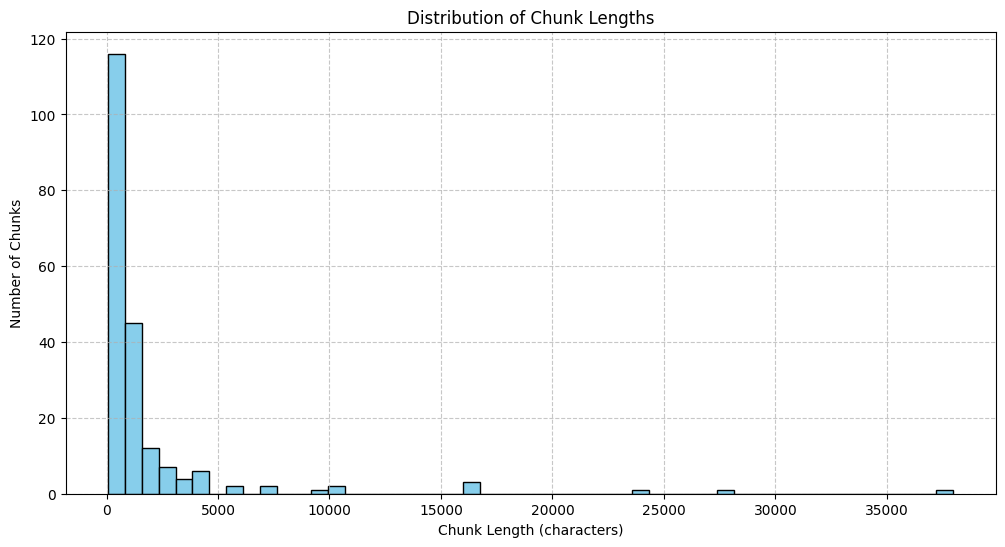

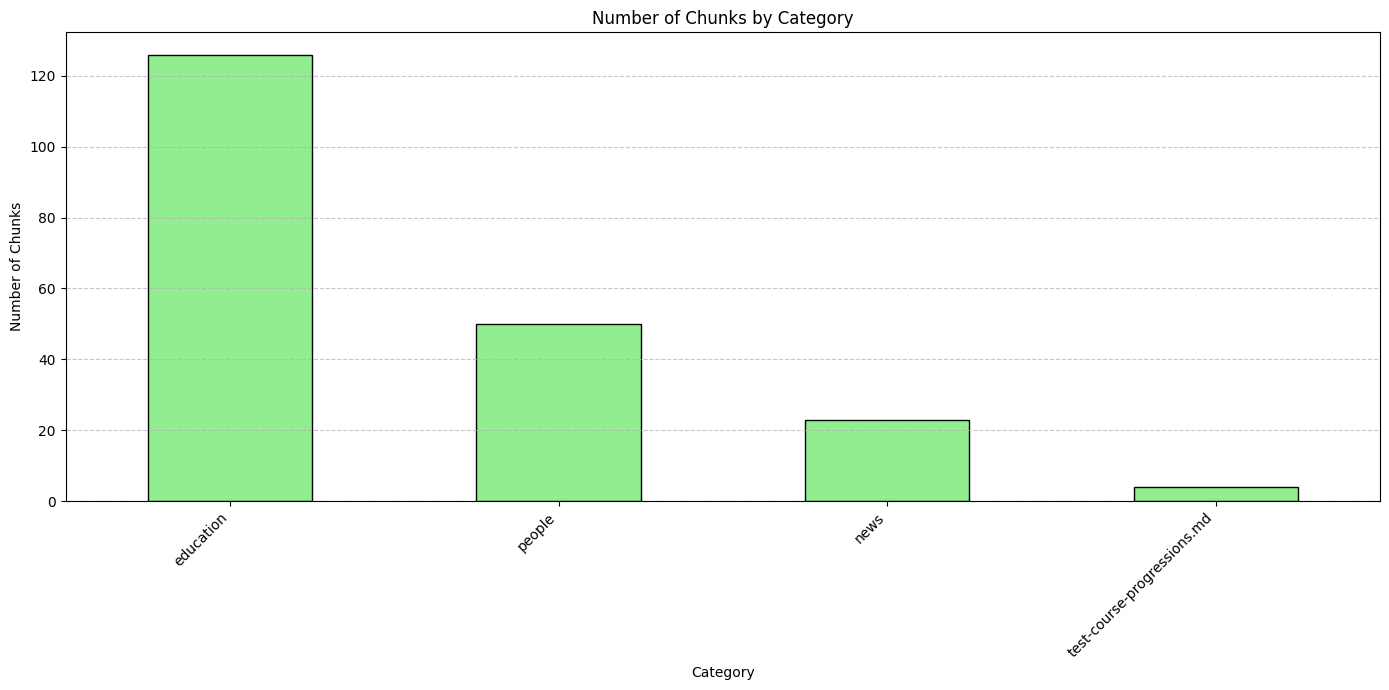

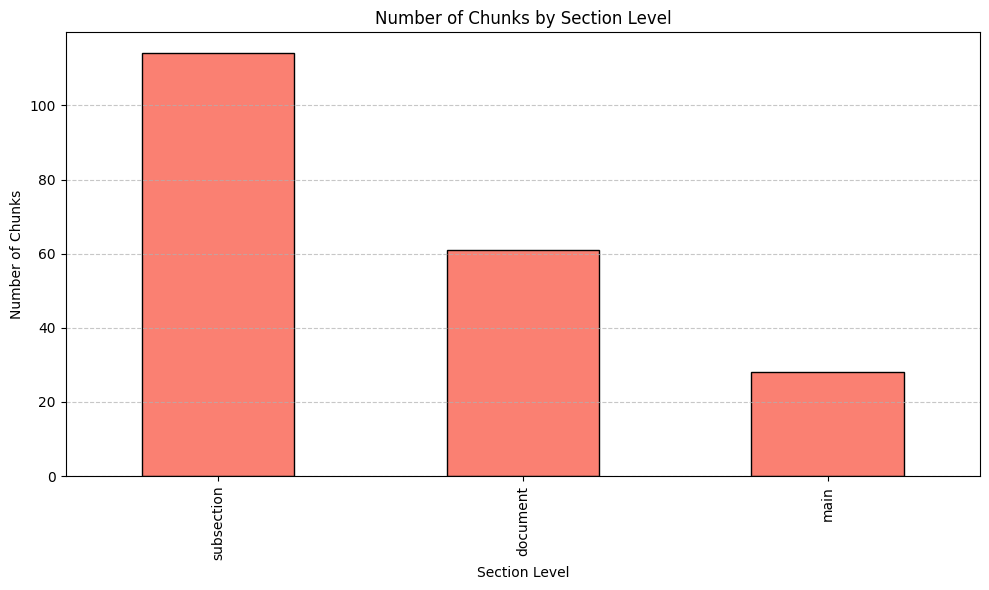

2025-05-12 22:11:38,616 - INFO - 1842225899 - <module> - 
Sample of chunk statistics:


,length,category,section_level,header_level
0,569,education,main,2
1,1129,education,main,2
2,611,education,main,2
3,597,education,main,2
4,991,education,main,2


2025-05-12 22:11:38,623 - INFO - 1842225899 - <module> - --- Header-Based Chunking Process Completed in 1.18 seconds ---
2025-05-12 22:11:38,624 - INFO - 1842225899 - <module> - Processed 78 files and created 203 chunks


In [9]:
# Execute the chunking process
logger.info("--- Starting Header-Based Markdown Chunking Process ---")
start_time = time.time()

# Check input directory exists
if not Path(INPUT_MARKDOWN_DIR).exists():
    logger.error(f"Input directory '{INPUT_MARKDOWN_DIR}' does not exist.")
else:
    # Process all markdown files
    files_processed, chunks_created = process_markdown_directory(
        INPUT_MARKDOWN_DIR,
        OUTPUT_CHUNKS_DIR
    )
    
    # Analyze results if chunks were created
    if chunks_created > 0:
        all_chunks_file = Path(OUTPUT_CHUNKS_DIR) / "all_chunks_by_header.json"
        chunks_df = analyze_chunks(all_chunks_file)
        
        if chunks_df is not None:
            logger.info("\nSample of chunk statistics:")
            display(chunks_df.head())

end_time = time.time()
logger.info(f"--- Header-Based Chunking Process Completed in {end_time - start_time:.2f} seconds ---")
logger.info(f"Processed {files_processed} files and created {chunks_created} chunks")

## Output Format

The chunks generated by this notebook are saved in JSON format and have the following structure:

```json
[
  {
    "page_content": "## Header Text\n\nActual content under this header...",
    "metadata": {
      "title": "Document Title",
      "category": "education",
      "date": "2025-05-04",
      "source_file": "path/to/original/file.md",
      "filename": "file.md",
      "section_level": "main",
      "section": "Main Section",
      "subsection": null,
      "header_level": 2,
      "header_text": "Header Text",
      "chunk_id": "filename_0",
      "document_title": "Document Title"
    }
  },
  // More chunks...
]
```

This format is compatible with most vector stores and can be directly used for embedding generation.